# 

# Creating the dataset for Equity Correlation

To generate the Neo4j-ready dataset, we randomly sample companies from the S&P 500 universe, download their OHLCV histories through the [DefeatBeta API](https://github.com/defeat-beta/defeatbeta-api/), and calculate daily percentage returns. Each batch of raw rows is enriched with metadata (sector, industry, country) so that graph nodes can later be filtered or grouped by these attributes.

After collecting the raw prices, we pivot the data into aligned time series for returns, volumes, and closing prices. Sliding windows, configured by `WINDOW_SIZE`, `STEP_SIZE`, `START_DATE`, and `END_DATE`, are used to compute correlation matrices, momentum, volatility, and volume statistics. Correlated ticker pairs above the `THRESHOLD` are written to `co_movements_windows.csv`, while per-ticker aggregates for each window land in `window_ticker_stats.csv`; the final `stocks.csv` captures the unique ticker metadata. These artifacts form the input layer for the correlation graph.

We start by loading configuration parameters from a `.env` file.

In [1]:
# Load .env with configuration parameters

from dotenv import load_dotenv
import os

load_dotenv()

THRESHOLD = float(os.getenv("THRESHOLD", 0.7)) # Correlation threshold
WINDOW_SIZE = int(os.getenv("WINDOW_SIZE", 30)) # Window size for rolling correlation calculations
STEP_SIZE = int(os.getenv("STEP_SIZE", 3)) # Step size for rolling windows
START_DATE = os.getenv("START_DATE", "2020-01-01") # Start date for data analysis
END_DATE = os.getenv("END_DATE", "2023-01-01") # End date for data analysis
NUMBER_TICKERS = int(os.getenv("NUMBER_TICKERS", 50)) # Number of tickers to analyze

print(f"Using THRESHOLD={THRESHOLD}, WINDOW_SIZE={WINDOW_SIZE}, STEP_SIZE={STEP_SIZE}, START_DATE={START_DATE}, END_DATE={END_DATE}")


Using THRESHOLD=0.5, WINDOW_SIZE=60, STEP_SIZE=3, START_DATE=2018-01-01, END_DATE=2025-10-31


We then proceed to create the dataset according to the specified parameters, and placing the data into a Pandas DataFrame for further processing.

In [2]:
import pandas as pd
from defeatbeta_api.data.ticker import Ticker 

import numpy as np

# Stock universe: S&P 500 companies as of Jan 2024
TICKERS = [
    'A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM',
    'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM',
    'ALB', 'ALGN', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP',
    'AMT', 'AMZN', 'ANET', 'AON', 'AOS', 'APA', 'APO', 'APP', 'APD', 'APH',
    'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXON', 'AXP', 'AZO',
    'BA', 'BAC', 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF.B', 'BG',
    'BIIB', 'BK', 'BKNG', 'BKR', 'BLDR', 'BLK', 'BMY', 'BR', 'BRK.B', 'BRO',
    'BSX', 'BX', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB', 'CBOE',
    'CBRE', 'CCI', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CF', 'CFG', 'CHD', 'CHRW',
    'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS',
    'CNC', 'CNP', 'COF', 'COIN', 'COO', 'COP', 'COR', 'COST', 'CPB', 'CPRT',
    'CPT', 'CRL', 'CRM', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTRA', 'CTSH',
    'CTVA', 'CVS', 'CVX', 'CZT', 'D', 'DAL', 'DASH', 'DD', 'DDOG', 'DE',
    'DECK', 'DELL', 'DFIN', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLR', 'DLTR',
    'DOC', 'DOV', 'DOW', 'DPZ', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXCM',
    'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'ELV', 'EME', 'EMR',
    'EOG', 'EPAM', 'EQIX', 'EQR', 'EQT', 'ERIE', 'ES', 'ESS', 'ETN', 'ETR',
    'EVRG', 'EW', 'EXC', 'EXE', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST',
    'FCX', 'FDS', 'FE', 'FFIV', 'FI', 'FIS', 'FITB', 'FLT', 'FMC', 'FOX',
    'FOXA', 'FRT', 'FSLR', 'FTNT', 'FTV', 'GD', 'GDDY', 'GE', 'GEHC', 'GEV',
    'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GNRC', 'GOOG', 'GOOGL', 'GPC', 'GPN',
    'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HCA', 'HD', 'HIG', 'HII',
    'HLT', 'HOLX', 'HON', 'HOOD', 'HPE', 'HPQ', 'HRL', 'HSIC', 'HST', 'HSY',
    'HUBB', 'HUM', 'HWM', 'IBM', 'IBKR', 'ICE', 'IDXX', 'IEX', 'IFF', 'INCY',
    'INTC', 'INTU', 'INVH', 'IQV', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J',
    'JBHT', 'JBL', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM', 'K', 'KDP', 'KEY',
    'KEYS', 'KHC', 'KIM', 'KKR', 'KLAC', 'KMB', 'KMI', 'KO', 'KR', 'KVUE',
    'L', 'LDOS', 'LEN', 'LH', 'LHX', 'LII', 'LIN', 'LKQ', 'LLY', 'LMT',
    'LNC', 'LNT', 'LOW', 'LRCX', 'LULU', 'LUV', 'LVS', 'LW', 'LYB', 'LYV',
    'MA', 'MAA', 'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT',
    'MET', 'META', 'MGM', 'MHK', 'MKC', 'MKS', 'MMC', 'MMM', 'MNST', 'MO',
    'MOH', 'MOS', 'MPC', 'MPWR', 'MRK', 'MRNA', 'MS', 'MSCI', 'MSFT', 'MSI',
    'MSTR', 'MTB', 'MTCH', 'MTD', 'MU', 'NCLH', 'NDAQ', 'NDSN', 'NEE', 'NEM',
    'NFLX', 'NI', 'NKE', 'NOC', 'NOW', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE',
    'NVDA', 'NVR', 'NWS', 'NWSA', 'NXPI', 'O', 'ODFL', 'OKE', 'OMC', 'ON',
    'ORCL', 'ORLY', 'OTIS', 'OXY', 'PANW', 'PAYC', 'PAYX', 'PCAR', 'PCG', 'PEAK',
    'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH', 'PHM', 'PKG', 'PLD',
    'PLTR', 'PM', 'PNC', 'PNR', 'PNW', 'PODD', 'POOL', 'PPG', 'PPL', 'PRU',
    'PSA', 'PSX', 'PTC', 'PWR', 'PXD', 'PYPL', 'Q', 'QCOM', 'RCL', 'REG',
    'REGN', 'RF', 'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG',
    'RTX', 'RVTY', 'SBAC', 'SBUX', 'SCHW', 'SHW', 'SJM', 'SLB', 'SMCI', 'SNA',
    'SNDK', 'SNPS', 'SO', 'SOLS', 'SOLV', 'SPG', 'SPGI', 'SRE', 'STE', 'STLD',
    'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP',
    'TDG', 'TDY', 'TECH', 'TEL', 'TER', 'TFC', 'TGT', 'TJX', 'TKO', 'TMO',
    'TMUS', 'TPR', 'TRGP', 'TRMB', 'TROW', 'TRV', 'TSCO', 'TSLA', 'TSN', 'TT',
    'TTD', 'TTWO', 'TXN', 'TXT', 'TYL', 'UAL', 'UBER', 'UDR', 'UHS', 'ULTA',
    'UNH', 'UNP', 'UPS', 'URI', 'USB', 'V', 'VICI', 'VLO', 'VLTO', 'VMC',
    'VRSK', 'VRSN', 'VRTX', 'VTR', 'VTRS', 'VZ', 'WAB', 'WAT', 'WBD', 'WDC',
    'WDAY', 'WEC', 'WELL', 'WFC', 'WM', 'WMB', 'WMT', 'WRB', 'WST', 'WTW',
    'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZS', 'ZTS'
]

# Convert START_DATE and END_DATE to datetime
start_date_datetime = pd.to_datetime(START_DATE)
end_date_datetime   = pd.to_datetime(END_DATE)

# Download OHLCV from defeatbeta API
data = pd.DataFrame()
# Select a random sample of NUMBER_TICKERS tickers
TICKERS = pd.Series(TICKERS).sample(n=NUMBER_TICKERS, random_state=1).tolist()
for i in range(0, len(TICKERS)):
    ticker = Ticker(TICKERS[i])
    ticker_info = ticker.info()
    ticker_industry = ticker_info['industry'].iloc[0] if not ticker_info['industry'].empty else None
    ticker_sector = ticker_info['sector'].iloc[0] if not ticker_info['sector'].empty else None
    ticker_country = ticker_info['country'].iloc[0] if not ticker_info['country'].empty else None
    ticker_data = ticker.price()
    
    ticker_data['report_date'] = pd.to_datetime(ticker_data['report_date'])

    # Filter ticker_data.report_date between start_date and end_date
    ticker_data = ticker_data[ticker_data['report_date'].between(start_date_datetime, end_date_datetime)]
    # Compute the percentage change between open and close prices
    ticker_data['pct_change'] = (ticker_data['close'] - ticker_data['open']) / ticker_data['open'] * 100
    # Add industry, sector, and country columns
    ticker_data['industry'] = ticker_industry if ticker_industry else 'N/A'
    ticker_data['sector'] = ticker_sector if ticker_sector else 'N/A'
    ticker_data['country'] = ticker_country if ticker_country else 'N/A'
    # If the number of rows > 0, print the ticker name
    if len(ticker_data) > 0:
        print(f"{TICKERS[i]}")
    
    # Add the ticker_data dataframe to a larger dataframe here
    data = pd.concat([data, ticker_data], axis=0).sort_index(axis=0)


[nltk_data] Downloading package punkt_tab to /tmp/nltk...
[nltk_data]   Package punkt_tab is already up-to-date!


______      __           _    ______      _        
|  _  \    / _|         | |   | ___ \    | |       
| | | |___| |_ ___  __ _| |_  | |_/ / ___| |_ __ _ 
| | | / _ \  _/ _ \/ _` | __| | ___ \/ _ \ __/ _` |
| |/ /  __/ ||  __/ (_| | |_  | |_/ /  __/ || (_| |
|___/ \___|_| \___|\__,_|\__| \____/ \___|\__\__,_|
📈:: Data Update Time ::	2025-11-28 ::
📈:: Software Version ::	0.0.25      ::
MKC
NVDA
AXON
BR
WDC
WMB
MOH
AMZN
J
CHTR
MTCH
ETN
CTSH
BMY
FOX
TER
LYV
DOW
DUK
MAS
MPC
MOS
XEL
BLK
PNW
AOS
NWS
EXE
GIS
FAST
MMC
IBM
TRGP
O
DDOG
LKQ
ABT
RVTY
PEP
NDAQ
TDG
VLO
HAL
NFLX
NEM
MCHP
SPGI
SJM
COF
EQT
HAS
ACGL
STLD
TT
BKNG
NOW
MET
AIZ
ORCL
OKE
CEG
K
PGR
PYPL
MRNA
REG
NUE
LULU
EQIX
MTD
MU
DVA
AMP
COST
URI
YUM
SYF
JBHT
DHI
KEYS
CTAS
SPG
ERIE
HOOD
TROW
LUV
WYNN
WAB
WAT
WDAY
SRE
ACN
STZ
ADSK
FSLR
CINF
HOLX
CPT


Let's have a look at the first few rows of the generated DataFrame to acquaint ourselves with its structure. We capture the ticker symbol, report date, open, close, high, low prices, volume and calculated percentage daily returns for each equity.

In [3]:
# Reset the index
data = data.reset_index(drop=True)

# Filter for NAN values
data = data.dropna()

# Print head of the final dataframe
print(data.head())

print(f"Total rows: {len(data)}")

  symbol report_date   open  close   high    low    volume  pct_change  \
0    FOX  2019-03-13  38.60  39.20  39.30  38.00    306000    1.554404   
1    DOW  2019-03-20  52.75  49.80  53.50  49.50   2350800   -5.592417   
2    EXE  2021-02-10  43.00  44.99  50.00  43.00   1836900    4.627907   
3   DDOG  2019-09-19  40.35  37.55  41.44  36.03  22025800   -6.939281   
4    CEG  2022-01-19  38.00  42.00  43.00  38.00    129900   10.526316   

                                industry                  sector  \
0                          Entertainment  Communication Services   
1                              Chemicals         Basic Materials   
2                          Oil & Gas E&P                  Energy   
3                   Software-Application              Technology   
4  Utilities-Independent Power Producers               Utilities   

         country  
0  United States  
1  United States  
2  United States  
3  United States  
4  United States  
Total rows: 189091


In [4]:
# Find which unique symbols are present in the data
unique_symbols = data['symbol'].unique()
print(f"Unique symbols in the data: {unique_symbols}")

Unique symbols in the data: ['FOX' 'DOW' 'EXE' 'DDOG' 'CEG' 'MRNA' 'HOOD' 'PYPL' 'KEYS' 'SYF' 'NWS'
 'WDAY' 'NOW' 'MPC' 'TRGP' 'CHTR' 'LULU' 'BR' 'FSLR' 'TDG' 'LYV' 'AMP'
 'AIZ' 'LKQ' 'MOH' 'WYNN' 'NDAQ' 'NFLX' 'ACN' 'AXON' 'EQIX' 'MET' 'BLK'
 'BKNG' 'NVDA' 'SRE' 'CTSH' 'URI' 'MTD' 'YUM' 'AMZN' 'STLD' 'WAT' 'DVA'
 'ERIE' 'ACGL' 'WAB' 'MAS' 'ORCL' 'CINF' 'LUV' 'EQT' 'MTCH' 'TER' 'MU'
 'NEM' 'AOS' 'WDC' 'ETN' 'DHI' 'O' 'DUK' 'J' 'ABT' 'COF' 'COST' 'VLO'
 'TROW' 'REG' 'IBM' 'CPT' 'HAS' 'MOS' 'MCHP' 'SJM' 'OKE' 'FAST' 'SPGI'
 'GIS' 'STZ' 'ADSK' 'XEL' 'PGR' 'HOLX' 'WMB' 'BMY' 'CTAS' 'JBHT' 'K' 'PNW'
 'HAL' 'PEP' 'TT' 'MMC' 'SPG' 'MKC' 'NUE' 'RVTY']


We now pivot the DataFrame to create aligned time series for each ticker, which will facilitate the computation of correlations and other statistics in subsequent steps.

In [5]:
returns = (
    data.pivot(index='report_date', columns='symbol', values='pct_change')
    .sort_index()
    .dropna(how='all')
)
volume_pivot = data.pivot(index='report_date', columns='symbol', values='volume').sort_index()
close_pivot = data.pivot(index='report_date', columns='symbol', values='close').sort_index()
volume_pivot = volume_pivot.reindex(index=returns.index, columns=returns.columns)
close_pivot = close_pivot.reindex(index=returns.index, columns=returns.columns)
print(returns.head())

symbol            ABT      ACGL       ACN      ADSK       AIZ       AMP  \
report_date                                                               
2018-01-02   1.013746 -3.190789  0.221498  1.689766 -2.178628 -0.427801   
2018-01-03  -0.118664 -0.033933  1.019674  2.224299  0.261965 -0.517799   
2018-01-04  -1.142857  0.373388  0.890323  1.761555  0.060006 -0.029457   
2018-01-05  -0.084688 -0.708024  0.676841 -1.972230  0.565813 -0.029357   
2018-01-08  -0.050977 -0.033933  0.991294  0.905633 -1.316441  0.950816   

symbol           AMZN       AOS      AXON      BKNG  ...       URI       VLO  \
report_date                                          ...                       
2018-01-02   1.450512  0.130187  0.113122  1.980470  ...  0.381679  0.661677   
2018-01-03   1.329519  0.487013  1.134216  1.895287  ...  0.424190  0.766904   
2018-01-04   0.381743  0.306452  0.111940 -1.701894  ... -2.189366  0.192699   
2018-01-05   0.952694  0.929338  0.000000  0.184597  ... -0.936416  0.4594

## Correlating equities over sliding windows

We now compute movement correlations over the defined sliding windows. This will tell us which equities tend to move in tandem, allowing us to identify clusters of related stocks and potential market trends.

In [6]:
# Get the last WINDOW_SIZE days of returns
last_window = returns.iloc[-WINDOW_SIZE:]
all_windows = returns.rolling(window=WINDOW_SIZE)

In [7]:
# Compute the correlation matrix for the last window
correlation_matrix = last_window.corr()
print(correlation_matrix)

symbol       ABT      ACGL       ACN      ADSK       AIZ       AMP      AMZN  \
symbol                                                                         
ABT     1.000000 -0.034427  0.144325  0.062853  0.199239  0.140421 -0.025033   
ACGL   -0.034427  1.000000  0.199359 -0.041031  0.439041  0.164831 -0.222947   
ACN     0.144325  0.199359  1.000000  0.428189  0.235677  0.226461  0.443436   
ADSK    0.062853 -0.041031  0.428189  1.000000  0.200889  0.166634  0.205427   
AIZ     0.199239  0.439041  0.235677  0.200889  1.000000  0.417057 -0.022704   
...          ...       ...       ...       ...       ...       ...       ...   
WDC    -0.128653 -0.185649 -0.137020 -0.124405  0.066818  0.040210  0.268218   
WMB     0.234708  0.325977 -0.067799 -0.037343  0.275136  0.068480 -0.374596   
WYNN   -0.061628 -0.073231  0.115549  0.093614  0.250831  0.328030  0.216998   
XEL     0.062833  0.494224  0.191706  0.045598  0.246734  0.048538 -0.243595   
YUM     0.260764  0.063560  0.343348  0.

Visually, we can represent these correlations as a heatmap. For example, for the last sliding window, we can see which equities exhibited strong positive (both went up or down together) or negative correlations (one went up while the other went down) in their daily returns.

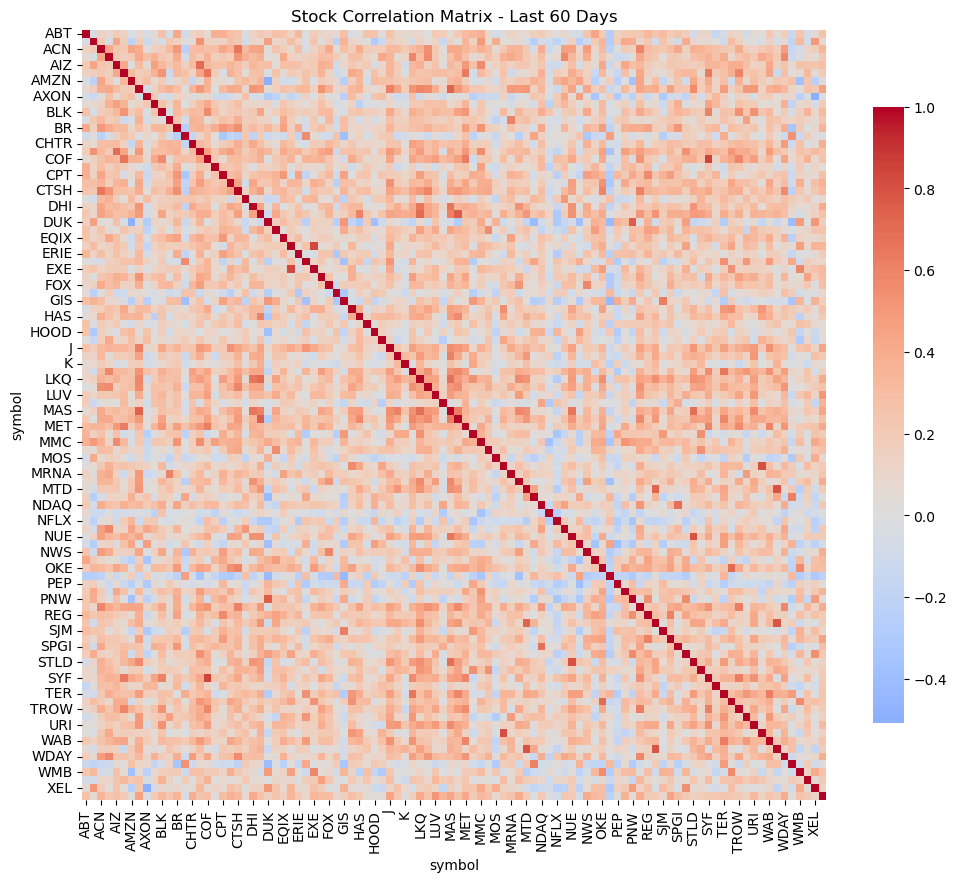

In [8]:
# Plot the correlation matrix as a heatmap, without annotations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, cbar_kws={"shrink": .8})
plt.title(f'Stock Correlation Matrix - Last {WINDOW_SIZE} Days')
plt.show()

We now compute correlations for **all** sliding windows.

In [9]:
# Compute correlation matrices for all rolling windows and store them in a dictionary with timestamps as keys
from tqdm.auto import tqdm

correlation_matrices = {}
# We start at index `window_size` so each slice is full-length
for i in tqdm(range(WINDOW_SIZE, len(returns) + 1, STEP_SIZE), desc="Computing correlation matrices"):
    window_data = returns.iloc[i-WINDOW_SIZE:i]
    corr_matrix = window_data.corr()

    end_date = window_data.index[-1]
    correlation_matrices[end_date] = corr_matrix
    
print(f"Computed {len(correlation_matrices)} correlation matrices.")
print(f"From: {list(correlation_matrices.keys())[0]} to {list(correlation_matrices.keys())[-1]}")

Computing correlation matrices:   0%|          | 0/637 [00:00<?, ?it/s]

Computed 637 correlation matrices.
From: 2018-03-28 00:00:00 to 2025-10-29 00:00:00


In [10]:
import itertools

tickers = list(next(iter(correlation_matrices.values())).columns)
total_pairs = len(list(itertools.combinations(tickers, 2)))

print("Total possible stock pairs:", total_pairs)

density = []

for window_id, corr in correlation_matrices.items():
    count = 0
    for u, v in itertools.combinations(corr.columns, 2):
        if abs(corr.loc[u, v]) >= THRESHOLD:
            count += 1
    density.append({"window_id": window_id, "correlated_pairs": count})

df_density = pd.DataFrame(density)
df_density["pct"] = df_density["correlated_pairs"] / total_pairs

df_density.describe()

positive_stats = []

ordered_ids = list(correlation_matrices.keys())

for i in range(len(ordered_ids) - 1):
    w1 = ordered_ids[i]
    w2 = ordered_ids[i+1]

    corr1 = correlation_matrices[w1]
    corr2 = correlation_matrices[w2]

    edges_1 = set()
    edges_2 = set()

    for u, v in itertools.combinations(corr1.columns, 2):
        if abs(corr1.loc[u, v]) >= THRESHOLD:
            edges_1.add((u, v))
        if abs(corr2.loc[u, v]) >= THRESHOLD:
            edges_2.add((u, v))

    new_edges = edges_2 - edges_1

    positive_stats.append({
        "src_window": w1,
        "dst_window": w2,
        "positives": len(new_edges),
        "pct_of_all_pairs": len(new_edges) / total_pairs
    })

df_pos = pd.DataFrame(positive_stats)
df_pos.describe()

base_positive_rate = df_pos["pct_of_all_pairs"].mean()
print(f"Base positive rate: {base_positive_rate:.6f}")


Total possible stock pairs: 4753
Base positive rate: 0.013981


And let's sample a few windows and see how correlations differ across time. There are periods where correlations are generally higher across the board, indicating more synchronized market movements, and others where correlations are lower, suggesting more independent stock behavior.

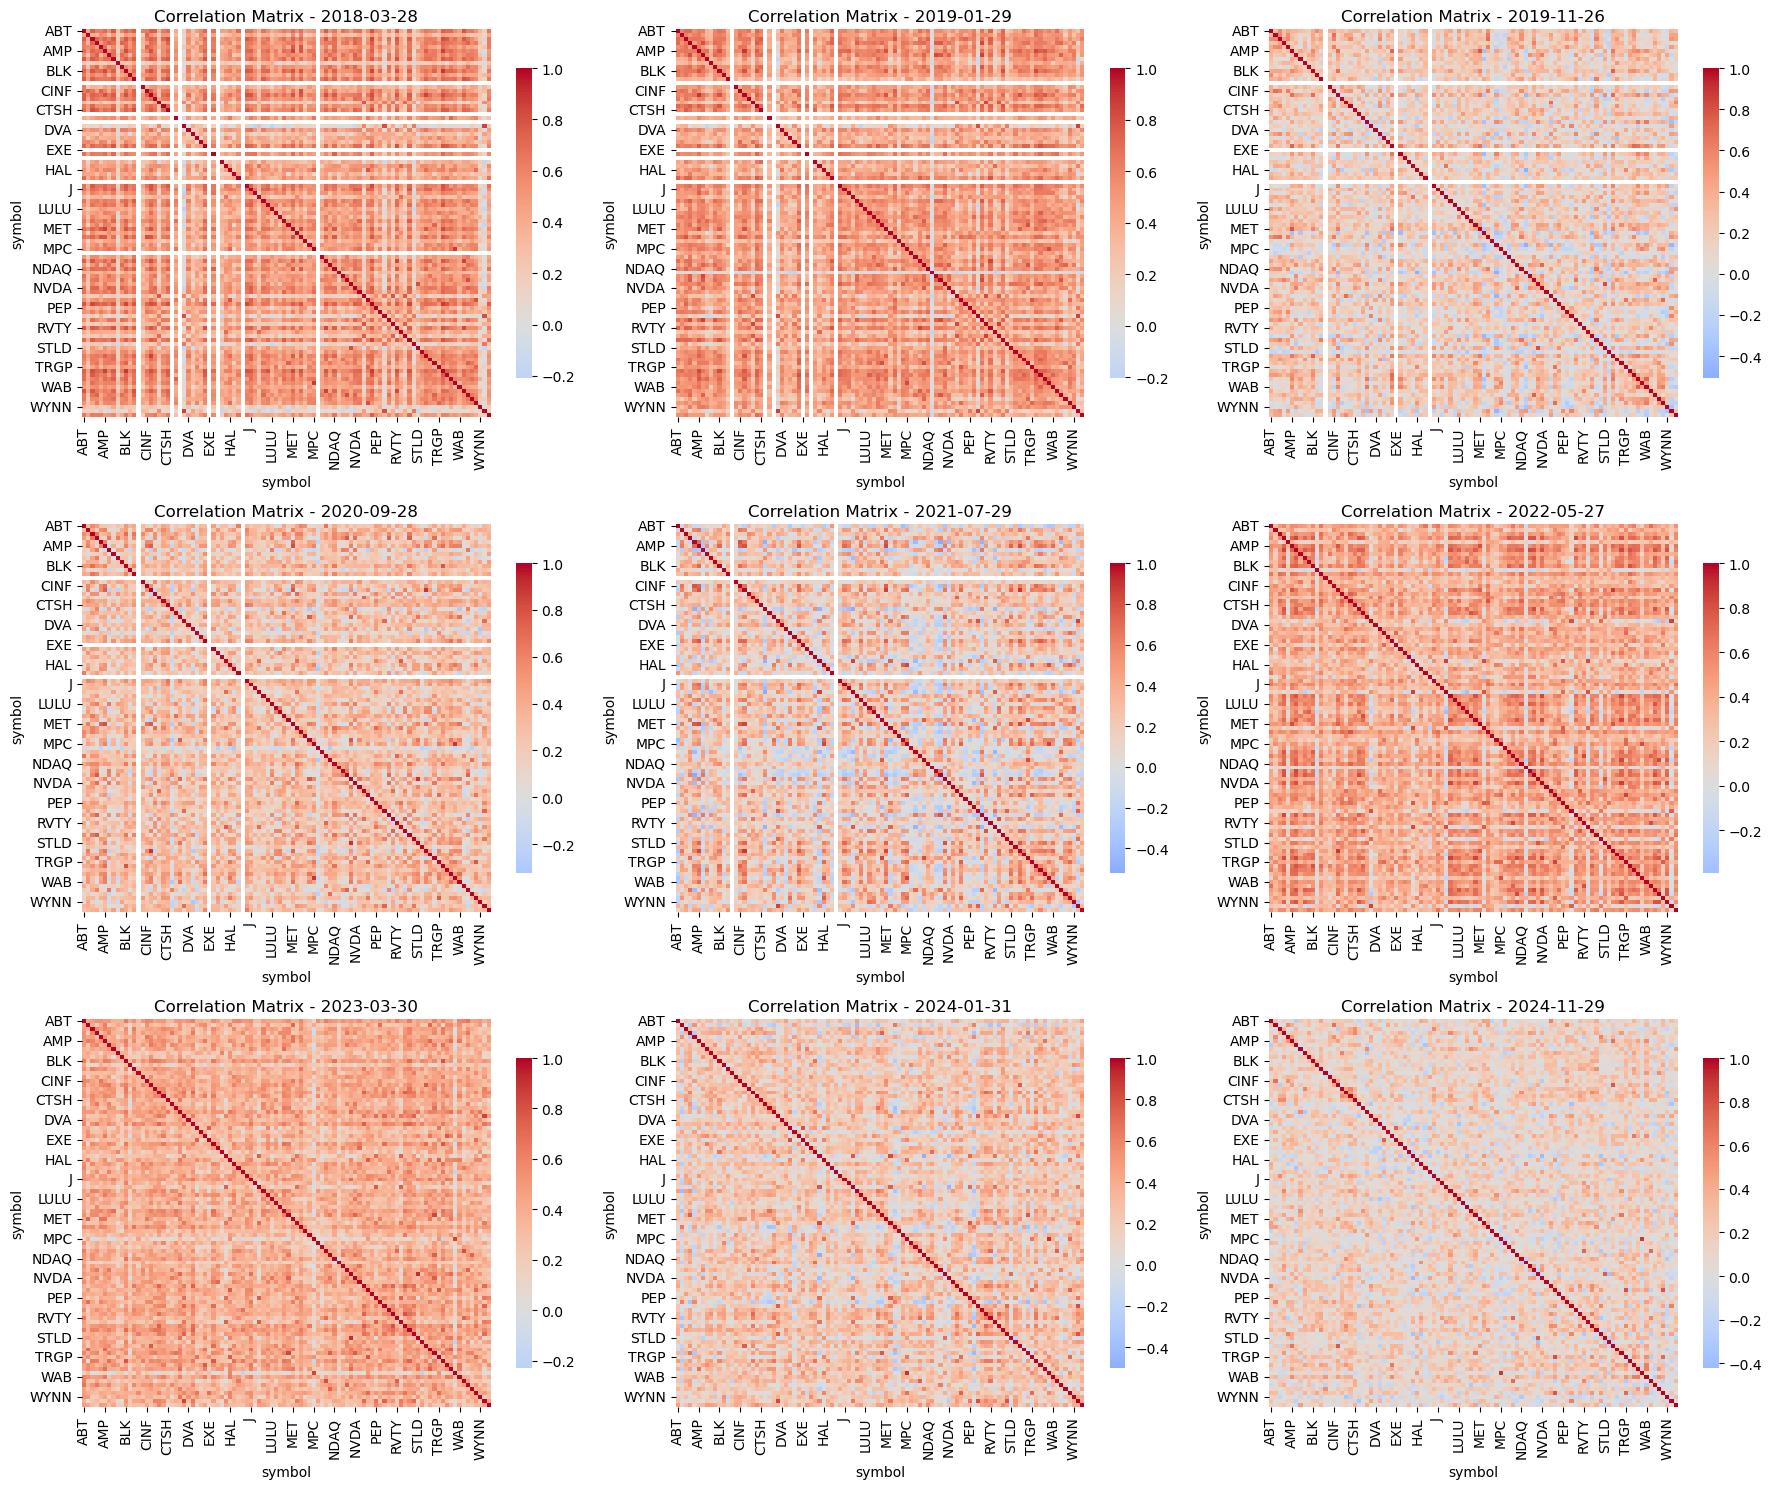

In [11]:
# Plot a 3x3 grid of heatmaps for a sample of 9 correlation matrices
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
sample_dates = list(correlation_matrices.keys())[::len(correlation_matrices)//9][:9]
for ax, date in zip(axes.flatten(), sample_dates):
    sns.heatmap(correlation_matrices[date], cmap='coolwarm', center=0, cbar_kws={"shrink": .8}, ax=ax)
    ax.set_title(f'Correlation Matrix - {date.date()}')
plt.tight_layout()
plt.show()

To complement the correlation data, we also compute per-ticker statistics within each sliding window, including average return, volatility, and average volume. These metrics provide additional context for understanding the behavior of each equity during the specified periods.

Volatility is computed as the annualized standard deviation of daily returns within the window. Momentum is calculated as the percentage change from the first to the last closing price in the window.

In [12]:
from itertools import combinations

window_size_str = f"{WINDOW_SIZE}d"

# returns: DataFrame of ticker returns, index = dates, columns = tickers
returns = returns.sort_index()

def make_window_id(start_ts, end_ts):
    """Nice stable ID like W_20240102_20240405"""
    start_str = start_ts.strftime("%Y%m%d")
    end_str = end_ts.strftime("%Y%m%d")
    return f"W_{start_str}_{end_str}"

def compute_momentum(close_series):
    close_series = close_series.dropna()
    if close_series.empty:
        return None
    start_price = close_series.iloc[0]
    end_price = close_series.iloc[-1]
    if start_price == 0:
        return None
    return (end_price - start_price) / start_price * 100

def compute_volatility(close_series):
    close_series = close_series.dropna()
    if close_series.empty:
        return None
    daily_returns = close_series.pct_change().dropna()
    return daily_returns.std() * np.sqrt(252) * 100  # Annualized volatility in percentage

edges = []
window_stats = []

Finally, we write the computed correlations and window statistics to CSV files for later ingestion into Neo4j.

In [ ]:

n = len(returns)

for end_idx in tqdm(range(WINDOW_SIZE, n + 1, STEP_SIZE), desc="Processing all windows"):
    window_data = returns.iloc[end_idx - WINDOW_SIZE:end_idx]

    start_ts = window_data.index[0]
    end_ts = window_data.index[-1]
    window_id = make_window_id(start_ts, end_ts)

    correlation_matrix = window_data.corr()
    window_volume = volume_pivot.reindex(index=window_data.index)
    window_close = close_pivot.reindex(index=window_data.index)
    mean_return = window_data.mean()
    volatility = window_close.apply(compute_volatility)
    avg_volume = window_volume.mean()
    vol_mean = volatility.mean()
    vol_std = volatility.std()
    momentum_series = window_close.apply(compute_momentum)
    avg_abs_momentum = (
        momentum_series.abs().replace(0, pd.NA).dropna().mean()
    )

    for ticker in window_data.columns:
        ticker_mean = mean_return.get(ticker)
        ticker_vol = volatility.get(ticker)
        ticker_volume = avg_volume.get(ticker)
        if pd.isna(ticker_mean) and pd.isna(ticker_vol) and pd.isna(ticker_volume):
            continue
        momentum_value = momentum_series.get(ticker)
        volatility_norm = None
        if (
            pd.notna(ticker_vol)
            and pd.notna(vol_mean)
            and pd.notna(vol_std)
            and vol_std != 0
        ):
            volatility_norm = (ticker_vol - vol_mean) / vol_std
        momentum_norm = None
        if (
            pd.notna(momentum_value)
            and pd.notna(avg_abs_momentum)
            and avg_abs_momentum != 0
        ):
            momentum_norm = momentum_value / avg_abs_momentum
        volume_norm = None
        if pd.notna(ticker_volume) and ticker_volume > 0:
            volume_norm = np.log(ticker_volume)
        window_stats.append({
            "window_id": window_id,
            "window": window_size_str,
            "start": start_ts.date().isoformat(),
            "end": end_ts.date().isoformat(),
            "ticker": ticker,
            "mean_return": float(ticker_mean) if pd.notna(ticker_mean) else None,
            "volatility": float(ticker_vol) if pd.notna(ticker_vol) else None,
            "avg_volume": float(ticker_volume) if pd.notna(ticker_volume) else None,
            "volatility_norm": float(volatility_norm) if volatility_norm is not None else None,
            "momentum": float(momentum_value) if momentum_value is not None else None,
            "momentum_norm": float(momentum_norm) if momentum_norm is not None else None,
            "volume_norm": float(volume_norm) if volume_norm is not None else None,
        })

    for i, j in combinations(correlation_matrix.columns, 2):
        c = correlation_matrix.loc[i, j]
        if pd.notna(c) and abs(c) >= THRESHOLD:
            edges.append({
                "window_id": window_id,
                "window": window_size_str,
                "start": start_ts.date().isoformat(),
                "end": end_ts.date().isoformat(),
                "src_ticker": i,
                "dst_ticker": j,
                "corr": float(c),
                "sign": "POS" if c > 0 else "NEG",
            })

# All windows in a single edges DataFrame
edges_df = pd.DataFrame(edges)
edges_df.to_csv("co_movements_windows.csv", index=False)
window_stats_df = pd.DataFrame(window_stats)
window_stats_df.to_csv("window_ticker_stats.csv", index=False)

# `data` has columns: symbol, industry, sector, country
# Make a lookup table so we don't repeatedly filter data in a loop
meta = (
    data[["symbol", "industry", "sector", "country"]]
    .drop_duplicates(subset="symbol")
    .set_index("symbol")
)

tickers = returns.columns

stocks_df = pd.DataFrame({
    "ticker": tickers,
    "industry": meta.loc[tickers, "industry"].values,
    "sector": meta.loc[tickers, "sector"].values,
    "country": meta.loc[tickers, "country"].values,
})

stocks_df.to_csv("stocks.csv", index=False)

Processing all windows:   0%|          | 0/637 [00:00<?, ?it/s]